<a href="https://colab.research.google.com/github/86lekwenshiung/Neural-Network-with-Tensorflow/blob/main/06_Transfer_Learning_with_Tensorflow_Part_3_Scaling_Up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0.0 Transfer Learning with Tensorflow Part 3 : Scaling Up
___

The objective on this part of the notebook is to beat the Food101 paper with 10% of the dataset.

* Original Food 101 paper : [Food101-Mining Discriminative Components](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf)
* Original Paper average accuracy of 50.76%.

 
**Workflow** for this notebook
* 1. Downloading and preparing 10% of the Food101 data (10% of training data)
* 2. Training a `feature extraction transfer learning model` on 10% training data.
* 3. `Fine-tuning` our feature extraction model
* 4. Saving and loaded our trained model
* 5. Evaluating the performance of our Food Vision model trained on 10% of the training data
* 6. Finding our model's most wrong predictions
* 7. Making predictions with our Food Vision model on custom images of food


<p align = 'center'>
  <img src = 'https://raw.githubusercontent.com/86lekwenshiung/Neural-Network-with-Tensorflow/main/images/06-ml-serial-experimentation.png'>
</p>

### Import Libraries
___


In [ ]:
import os
import zipfile
import pathlib
import datetime

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory

from sklearn.metrics import accuracy_score , confusion_matrix
from sklearn.metrics import classification_report

import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Check GPU
___

In [ ]:
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))
!nvidia-smi

2.6.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Mon Sep 27 08:58:01 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P8    32W / 149W |      3MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
               

### General Functions
___

In [ ]:
# Refer to Tensorboard Doc String : https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard
def create_tensorboard_callback(dir_name , experiment_name):
  """
  Creates a TensorBoard callback instand to store log files.
  Stores log files with the filepath:
    "dir_name/experiment_name/current_datetime/"
  Args:
    dir_name: target directory to store TensorBoard log files
    experiment_name: name of experiment directory (e.g. efficientnet_model_1)
  """

  log_dir = dir_name + '/' + experiment_name + '/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir)
  
  print(f'Saving Tensorboard log files to {log_dir}')

  return tensorboard_callback

In [ ]:
def make_confusion_matrix

In [ ]:
def plot_loss_curves(history):
  loss = history.history['loss']
  accuracy = history.history['accuracy']

  val_loss = history.history['val_loss']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  plt.figure(figsize = (12,8))

  #Plot Accuracy
  plt.subplot(1,2,1)
  plt.plot(epochs , loss , label = 'training loss')
  plt.plot(epochs , val_loss , label = 'validation loss')
  plt.title('loss')
  plt.xlabel('epochs')
  plt.legend()

  #Plot Accuracy
  plt.subplot(1,2,2)
  plt.plot(epochs , accuracy , label = 'training accuracy')
  plt.plot(epochs , val_accuracy , label = 'validation accuracy')
  plt.title('accuracy')
  plt.xlabel('epochs')
  plt.legend()


In [ ]:
def compare_loss_curves(history_old , history_new , epochs):
 
  # Define Original History
  loss = history_old.history['loss']
  accuracy = history_old.history['accuracy']

  val_loss = history_old.history['val_loss']
  val_accuracy = history_old.history['val_accuracy']

  # Define New History
  total_loss = loss + history_new.history['loss']
  total_accuracy = accuracy + history_new.history['accuracy']

  total_val_loss = val_loss + history_new.history['val_loss']
  total_val_accuracy = val_accuracy + history_new.history['val_accuracy']  

  plt.figure(figsize = (12,8))

  #Plot Accuracy
  plt.subplot(1,2,1)
  plt.plot(total_loss , label = 'training loss')
  plt.plot(total_val_loss , label = 'validation loss')
  plt.title('Train and Validation Loss')
  plt.xlabel('epochs')
  plt.axvline(x = epochs , 
             label = 'Start Fine Tuning',
             ymin = 0 ,
             ymax = 1,
             color = 'green')    
  plt.legend()

  #Plot Accuracy
  plt.subplot(1,2,2)
  plt.plot(total_accuracy , label = 'training accuracy')
  plt.plot(total_val_accuracy , label = 'validation accuracy')
  plt.title('Train and Validation Accuracy')
  plt.xlabel('epochs')
  plt.axvline(x = epochs , 
             label = 'Start Fine Tuning',
             ymin = 0 ,
             ymax = 1,
             color = 'green')  
  plt.legend()

In [ ]:
def unzip_data(filename):
  """
  Unzips filename into the current working directory.
  Args:
    filename (str): a filepath to a target zip folder to be unzipped.
  """

  zip_ref = zipfile.ZipFile(filename , 'r')
  zip_ref.extractall()
  zip_ref.close()  

In [ ]:
def walk_through_dir(dir_path):
  for dirpath , dirnames , filenames in os.walk(dir_path):
    print(f'There are {len(filenames)} files and {len(dirnames)} in {dirpath}')

#1.0 Getting Data from Food101
___

Using pretrained model within tf.keras.application and apply them to our own food images.
Source : https://www.tensorflow.org/api_docs/python/tf/keras/applications

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip 

--2021-09-27 08:58:02--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.5.128, 74.125.206.128, 64.233.184.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.5.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   127MB/s    in 12s     

2021-09-27 08:58:13 (133 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [ ]:
unzip_data('101_food_classes_10_percent.zip')

### 1.1 Exploring File Path
___

In [ ]:
walk_through_dir('101_food_classes_10_percent')

There are 0 files and 2 in 101_food_classes_10_percent
There are 0 files and 101 in 101_food_classes_10_percent/test
There are 250 files and 0 in 101_food_classes_10_percent/test/caprese_salad
There are 250 files and 0 in 101_food_classes_10_percent/test/spring_rolls
There are 250 files and 0 in 101_food_classes_10_percent/test/escargots
There are 250 files and 0 in 101_food_classes_10_percent/test/pho
There are 250 files and 0 in 101_food_classes_10_percent/test/baby_back_ribs
There are 250 files and 0 in 101_food_classes_10_percent/test/cannoli
There are 250 files and 0 in 101_food_classes_10_percent/test/pizza
There are 250 files and 0 in 101_food_classes_10_percent/test/hamburger
There are 250 files and 0 in 101_food_classes_10_percent/test/greek_salad
There are 250 files and 0 in 101_food_classes_10_percent/test/churros
There are 250 files and 0 in 101_food_classes_10_percent/test/beef_tartare
There are 250 files and 0 in 101_food_classes_10_percent/test/pancakes
There are 250 fil

### 1.2 Setting Up File Path
___

In [ ]:
train_dir = '/content/101_food_classes_10_percent/train'
test_dir = '/content/101_food_classes_10_percent/test'

### 1.3 Setting up Class Name
___

In [ ]:
data_dir = pathlib.Path(train_dir)

for item in data_dir.glob('*'):
  print(item.name)

caprese_salad
spring_rolls
escargots
pho
baby_back_ribs
cannoli
pizza
hamburger
greek_salad
churros
beef_tartare
pancakes
bread_pudding
beignets
club_sandwich
edamame
eggs_benedict
baklava
pork_chop
gyoza
hot_dog
french_onion_soup
gnocchi
crab_cakes
steak
peking_duck
foie_gras
lasagna
shrimp_and_grits
tacos
french_fries
paella
macarons
scallops
nachos
pulled_pork_sandwich
sashimi
falafel
deviled_eggs
bibimbap
oysters
hot_and_sour_soup
grilled_cheese_sandwich
chocolate_cake
filet_mignon
tuna_tartare
donuts
panna_cotta
red_velvet_cake
waffles
fish_and_chips
pad_thai
breakfast_burrito
french_toast
sushi
chicken_quesadilla
tiramisu
garlic_bread
hummus
chocolate_mousse
huevos_rancheros
lobster_bisque
caesar_salad
fried_rice
macaroni_and_cheese
chicken_wings
cheese_plate
croque_madame
strawberry_shortcake
fried_calamari
chicken_curry
dumplings
spaghetti_bolognese
miso_soup
takoyaki
frozen_yogurt
carrot_cake
cheesecake
spaghetti_carbonara
prime_rib
bruschetta
clam_chowder
beet_salad
mussels
r

In [ ]:
class_name  = [item.name for item in data_dir.glob('*')]
print(f'There are {len(class_name)} labels in training directory')

There are 101 labels in training directory


In [ ]:
len(class_name)

101

### 1.4 Visualising Data
___

In [ ]:
img_size = (224 ,224)
batch_size = 32

train_data_10_percent = image_dataset_from_directory(directory = train_dir,
                                                     label_mode = 'categorical',
                                                     image_size = img_size,
                                                     batch_size = batch_size)

test_data_10_percent = image_dataset_from_directory(directory = test_dir,
                                                    label_mode = 'categorical',
                                                    image_size = img_size,
                                                    batch_size = batch_size,
                                                    shuffle = False)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


In [ ]:
# Getting class name

# train_data_10_percent.class_names 
# test_data_10_percent.class_names

In [ ]:
# 224 x 224 img size with 3 color channel. Total 101 Unique label.
test_data_10_percent

<BatchDataset shapes: ((None, 224, 224, 3), (None, 101)), types: (tf.float32, tf.float32)>

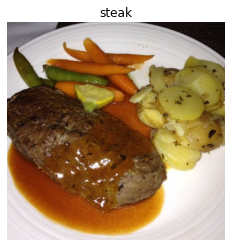

In [ ]:
# Training Path + Random Food Selector

label = random.sample(class_name , 1)[0]
sample_path = '/content/101_food_classes_10_percent/train/' + label

random_image = sample_path + '/' + random.choice(os.listdir(sample_path))

img = plt.imread(random_image)
plt.axis('off')
plt.imshow(img)
plt.title(label);

In [ ]:
def random_image_generator(target_path):
  label = random.sample(class_name , 1)[0]
  sample_path = '/content/101_food_classes_10_percent/' + target_path + '/' + label

  random_image = sample_path + '/' + random.choice(os.listdir(sample_path))

  img = plt.imread(random_image)
  plt.axis('off')
  plt.imshow(img)
  plt.title(label);

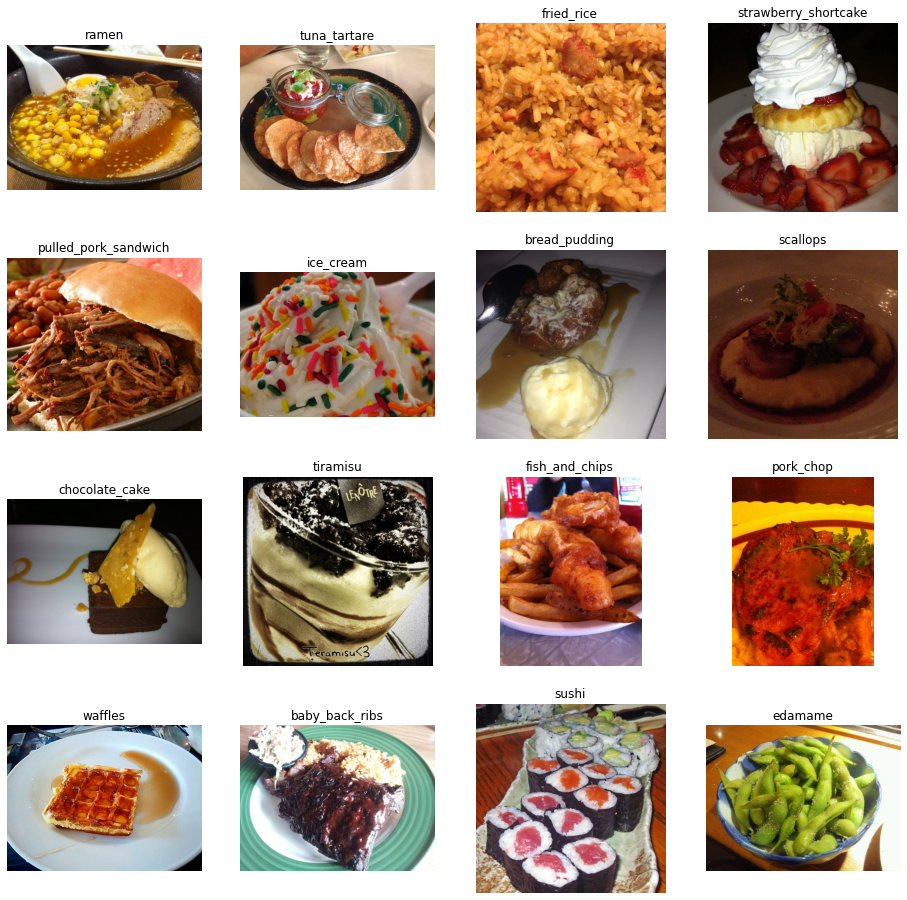

In [ ]:
plt.figure(figsize = (16,16))

for i in range(16):
  plt.subplot(4,4,i+1)
  random_image_generator('train')



### 1.5 Defining Preprocessing Steps
___

* Create Model Checkpoint callback
* Create a data augmentation layer
* Build Functional EfficientNetB0 model with no top layers
* Compile our model
* Feature Extraction for 5 Full Passes

# 2.0 Building Baseline Model
___

### 2.1 Create Model Checkpoints
___

Model checkpoint callback saved our model (the model of weights) during training. This is useful where we long training time so that we can return and start where we left off.

link : https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint

In [ ]:
checkpoint_filepath = '101_food_classes_10_percent_model_checkpoints_weights/checkpoint'

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                                                          filepath = checkpoint_filepath , 
                                                          monitor = 'val_accuracy' , 
                                                          verbose = 0 , 
                                                          save_best_only = True,
                                                          save_weights_only = True , 
                                                          mode = 'auto' , 
                                                          save_freq = 'epoch',
                                                          options = None
)

### 2.2 Create Data Augmentation layer
___

In [ ]:
from tensorflow.keras.layers.experimental import preprocessing

In [ ]:
# Create a data augmentation stage with horizontal flipping, rotations, zooms

data_augmentation = keras.Sequential([
                                      preprocessing.RandomFlip('horizontal'),
                                      preprocessing.RandomRotation(0.2),
                                      preprocessing.RandomZoom(0.2),
                                      preprocessing.RandomHeight(0.2),
                                      preprocessing.RandomWidth(0.2)
                                      # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNetB0
],name ="data_augmentation")

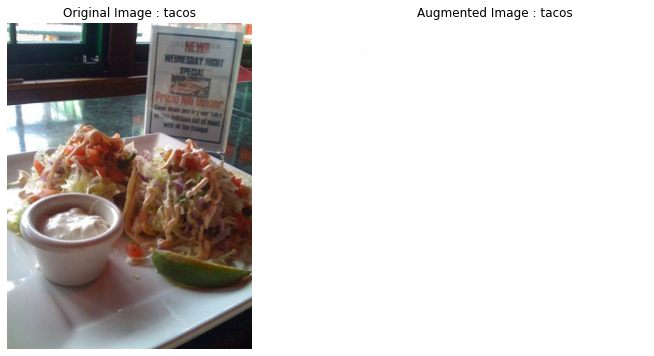

In [ ]:
label = random.sample(class_name , 1)[0]
sample_path = '/content/101_food_classes_10_percent/train/' + label

random_image = sample_path + '/' + random.choice(os.listdir(sample_path))

plt.figure(figsize = (12,6))

plt.subplot(1,2,1)
img = plt.imread(random_image)
plt.axis('off')
plt.imshow(img)
plt.title(f'Original Image : {label}')

plt.subplot(1,2,2)
aug_img = data_augmentation(img)
plt.axis('off')
plt.imshow(aug_img)
plt.title(f'Augmented Image : {label}');

### 2.3 Build Functional EfficientNetB0 model with no top layers
___

In [ ]:
# Call base model from tf application
base_model = tf.keras.applications.EfficientNetB0(include_top = False)
base_model.trainable = False

# input layers
inputs = tf.keras.layers.Input(shape = (224, 224,3) , name = 'input_layer')

#Parsing through Data data augmentation
x = data_augmentation(inputs)

x = base_model(x , training = False) #put the model in inference mode so weights which need to stay forzen , stay frozen

# Global Average Pool the model
x = tf.keras.layers.GlobalAveragePooling2D()(x)

# Output layer
outputs = tf.keras.layers.Dense(101 , activation = 'softmax' , name = 'output_layer')(x)

# Build the model
model_ENetB0 = tf.keras.Model(inputs = inputs,
                              outputs = outputs)

16719872/16705208 [==============================] - 0s 0us/step


In [ ]:
model_ENetB0.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 101)               129381    
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________


### 2.4 Compile our model
___

In [ ]:
model_ENetB0.compile(optimizer = tf.keras.optimizers.Adam(),
                     loss = tf.keras.losses.CategoricalCrossentropy(),
                     metrics = 'accuracy')

In [ ]:
history_1 = model_ENetB0.fit(train_data_10_percent,
                             epochs = 5,
                             callbacks = [create_tensorboard_callback('save_dir' , 'model') , checkpoint_callback],
                             validation_data = test_data_10_percent,
                             validation_steps = len(test_data_10_percent))

Saving Tensorboard log files to save_dir/model/20210926-180931
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


237/237 [==============================] - 234s 828ms/step - loss: 3.4740 - accuracy: 0.2458 - val_loss: 2.4412 - val_accuracy: 0.4556
Epoch 2/5
237/237 [==============================] - 173s 731ms/step - loss: 2.3527 - accuracy: 0.4591 - val_loss: 2.0109 - val_accuracy: 0.5112
Epoch 3/5
237/237 [==============================] - 167s 705ms/step - loss: 1.9744 - accuracy: 0.5324 - val_loss: 1.8464 - val_accuracy: 0.5352
Epoch 4/5
237/237 [==============================] - 159s 666ms/step - loss: 1.7640 - accuracy: 0.5749 - val_loss: 1.7669 - val_accuracy: 0.5463
Epoch 5/5
237/237 [==============================] - 153s 646ms/step - loss: 1.6067 - accuracy: 0.6013 - val_loss: 1.7134 - val_accuracy: 0.5563


### 2.5 Evaluating results
___

In [ ]:
model_ENetB0.evaluate(test_data_10_percent)

790/790 [==============================] - 101s 128ms/step - loss: 1.7134 - accuracy: 0.5563


[1.713444471359253, 0.5562772154808044]

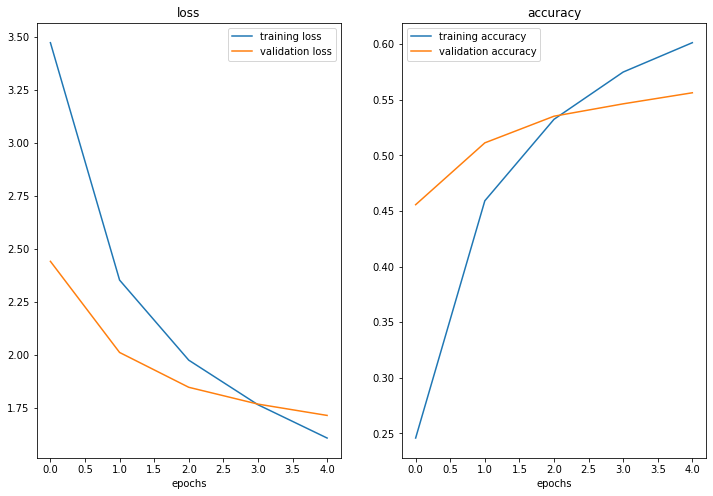

In [ ]:
plot_loss_curves(history_1)

# 3.0 Fine tuning model
___

In [ ]:
# Accessing layers in model

for layers in model_ENetB0.layers:
  print(layers , layers.trainable)

<keras.engine.input_layer.InputLayer object at 0x7fef4ac8ed10> True
<keras.engine.sequential.Sequential object at 0x7fef4acef410> True
<keras.engine.functional.Functional object at 0x7fef4ac61710> False
<keras.layers.pooling.GlobalAveragePooling2D object at 0x7fef4ac8ec50> True
<keras.layers.core.Dense object at 0x7fef499441d0> True


In [ ]:
# Accessing layers in the functional API

for index , layers in enumerate(model_ENetB0.layers[2].layers[:20]):
  print(index , layers , layers.trainable)

0 <keras.engine.input_layer.InputLayer object at 0x7fef4ad4e510> False
1 <keras.layers.preprocessing.image_preprocessing.Rescaling object at 0x7fefc180ead0> False
2 <keras.layers.preprocessing.normalization.Normalization object at 0x7fefc50ea690> False
3 <keras.layers.convolutional.ZeroPadding2D object at 0x7fef4aca1b90> False
4 <keras.layers.convolutional.Conv2D object at 0x7fef4acae610> False
5 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fef4ad4ec90> False
6 <keras.layers.core.Activation object at 0x7fef4ac61990> False
7 <keras.layers.convolutional.DepthwiseConv2D object at 0x7fef49b84110> False
8 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fef49b84cd0> False
9 <keras.layers.core.Activation object at 0x7fef4acae790> False
10 <keras.layers.pooling.GlobalAveragePooling2D object at 0x7fef49b95b50> False
11 <keras.layers.core.Reshape object at 0x7fef49ba04d0> False
12 <keras.layers.convolutional.Conv2D object at 0x7f

In [ ]:
# Currently there are 0 trainable layers in our base model because we had frozen the layers in earlier initiatiation

print(len(model_ENetB0.layers[2].trainable_variables))

0


### 3.1 Fine Tuning Model
___

In [ ]:
# Redefine base model
base_model.trainable = True

# Refreeze every layer except the last 5
for layers in base_model.layers[:-4]:
  layers.trainable = False

In [ ]:
print(f' No. of Trainable Layers : {len(base_model.trainable_variables)}')
print(f' No. of layers in model : {len(base_model.layers)}')

 No. of Trainable Layers : 5
 No. of layers in model : 237


### 3.2 Compile out model
___

In [ ]:
model_ENetB0.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001), # lower the learning rate during fine tuning
                     loss = tf.keras.losses.CategoricalCrossentropy(),
                     metrics = 'accuracy')

In [ ]:
initial_epochs = 5

fine_tune_epochs = initial_epochs + 5

history_2 = model_ENetB0.fit(train_data_10_percent,
                             epochs = fine_tune_epochs,
                             initial_epoch = history_1.epoch[-1],
                             callbacks = [create_tensorboard_callback('save_dir' , 'model_2') , checkpoint_callback],
                             validation_data = test_data_10_percent,
                             validation_steps = len(test_data_10_percent))

Saving Tensorboard log files to save_dir/model_2/20210926-184519
Epoch 5/10


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


237/237 [==============================] - 166s 664ms/step - loss: 1.3909 - accuracy: 0.6545 - val_loss: 1.6501 - val_accuracy: 0.5630
Epoch 6/10
237/237 [==============================] - 152s 642ms/step - loss: 1.2859 - accuracy: 0.6692 - val_loss: 1.6185 - val_accuracy: 0.5696
Epoch 7/10
237/237 [==============================] - 148s 622ms/step - loss: 1.2104 - accuracy: 0.6894 - val_loss: 1.6118 - val_accuracy: 0.5710
Epoch 8/10
237/237 [==============================] - 147s 620ms/step - loss: 1.1635 - accuracy: 0.6977 - val_loss: 1.6076 - val_accuracy: 0.5733
Epoch 9/10
237/237 [==============================] - 145s 611ms/step - loss: 1.1098 - accuracy: 0.7092 - val_loss: 1.6000 - val_accuracy: 0.5758
Epoch 10/10
237/237 [==============================] - 144s 608ms/step - loss: 1.0659 - accuracy: 0.7133 - val_loss: 1.5937 - val_accuracy: 0.5775


### 3.3 Evaluating results
___

In [ ]:
model_fine_tuned_results = model_ENetB0.evaluate(test_data_10_percent)

790/790 [==============================] - 101s 127ms/step - loss: 1.5937 - accuracy: 0.5775


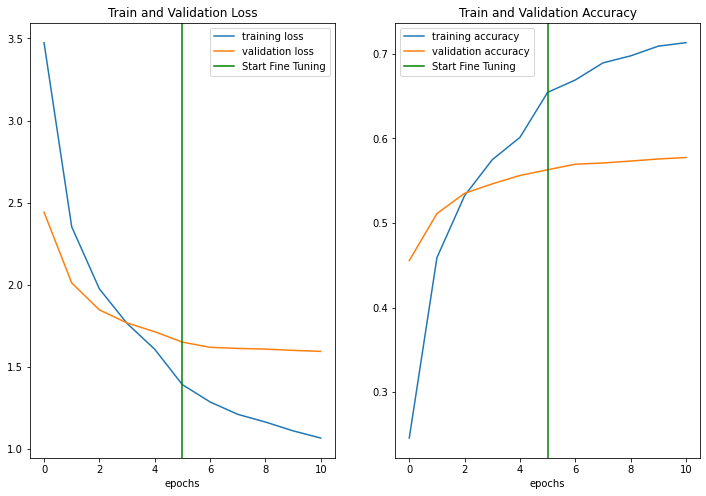

In [ ]:
compare_loss_curves(history_1,
                    history_2,
                    epochs = initial_epochs)

# 4.0 Saving and Loading Model
___

In [ ]:
# Saving into my google drive folder
model_ENetB0.save('/content/drive/MyDrive/Colab Notebooks/101_food_classes_10_percent')

In [ ]:
# Loading our model

laoded_model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/101_food_classes_10_percent')

In [ ]:
# Fine Tuned Model Results
model_fine_tuned_results

In [ ]:
# Checking loaded model results same as original trained model
loaded_model_results = laoded_model.evaluate(test_data_10_percent)

790/790 [==============================] - 137s 133ms/step - loss: 1.5937 - accuracy: 0.5775


# 5.0 Evaluating performance of model by predicting images
___

### 5.1 Visualising prediction on 1 random test data
___

In [ ]:
pred_prob = laoded_model.predict(test_data_10_percent , verbose = 1)

790/790 [==============================] - 91s 113ms/step


In [ ]:
# Visualing prediction of a single pred_prob
pred_prob[0]

array([1.93525046e-01, 1.59361065e-04, 1.51020169e-01, 3.08192739e-07,
       6.31636703e-06, 4.81501411e-06, 2.45777977e-04, 1.85981153e-05,
       1.89597048e-02, 8.79658270e-04, 1.01312144e-05, 4.15630393e-06,
       3.80322966e-03, 1.77673314e-06, 4.62672114e-02, 7.14758644e-04,
       2.60756606e-05, 4.02735639e-03, 1.01979903e-03, 6.13060956e-06,
       2.67949392e-04, 1.50067237e-04, 7.65343197e-04, 1.69124163e-04,
       1.04262865e-04, 1.11712527e-03, 2.40517460e-04, 8.69924261e-05,
       1.35847285e-01, 2.21834402e-03, 5.40249994e-06, 1.55195280e-03,
       1.09024020e-03, 9.05849674e-07, 4.94455500e-03, 1.78695700e-05,
       4.23421938e-04, 5.71241719e-04, 3.37595083e-02, 3.95942916e-05,
       1.94982887e-04, 6.51773473e-04, 2.17978912e-03, 7.99297050e-06,
       5.16077052e-05, 8.56541883e-05, 9.40093189e-04, 3.71794187e-04,
       2.78232142e-06, 2.21467428e-02, 2.82251975e-04, 2.41962589e-05,
       1.49009839e-01, 1.17015243e-02, 1.68075894e-05, 5.51486649e-02,
      

In [ ]:
# We have 101 prediction classes. 
# The sum of prediction probality will sum up to 1.0
print(f'Sum of prediction : {sum(pred_prob[0])}')
print(f'Shape of Prediction : {len(pred_prob[0])}')

max_value_index = np.argmax(pred_prob[0])
                            
print(f'Location where highest prediction is at : {max_value_index}')
print(f'Value of maximum prediction probability : {pred_prob[0][max_value_index]}')
print(f'Label of food corresponding the highest prob: {test_data_10_percent.class_names[max_value_index]}')

Sum of prediction : 0.9999999995831104
Shape of Prediction : 101
Location where highest prediction is at : 0
Value of maximum prediction probability : 0.1935250461101532
Label of food corresponding the highest prob: apple_pie


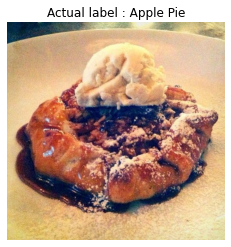

In [ ]:
sample_path = '/content/101_food_classes_10_percent/test/apple_pie/' 
random_image = sample_path + os.listdir(sample_path)[0]

img = plt.imread(random_image)
plt.axis('off')
plt.imshow(img)
plt.title('Actual label : Apple Pie');

### 5.2 Making Prediction with 25,250 test data
___

In [ ]:
# Batch dataset in the form of 2 tuples : images and labels
print(test_data_10_percent)

<BatchDataset shapes: ((None, 224, 224, 3), (None, 101)), types: (tf.float32, tf.float32)>


In [ ]:
y_labels = []
for images , labels in test_data_10_percent.unbatch():
  y_labels.append(labels.numpy().argmax())

In [ ]:
# Test Labels are in order , as when we load in , we set shuffle  = False
# Compare actual labels with prediction class
y_labels[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
# Base on 1st 10 comparison , we could see from the array that 3 out of 10 is already wrongly predicted
pred_class = pred_prob.argmax(axis = 1)
pred_class[:10]

array([ 0,  0,  0,  0,  0, 78, 29,  0,  9,  0])

### 5.3 Checking that our model predictions is in the same order as our test labels.
___

* Recall that our fine tuned model accuracy is at ~56%

In [ ]:
# Comparing our loaded model results with test prediction accuracy , we can conclude that the labels are in order
model_accuracy = accuracy_score(y_true = y_labels,
                                y_pred = pred_class)

print(model_accuracy)
print(loaded_model_results)
np.isclose(model_accuracy , loaded_model_results[1])

0.5775049504950495
[1.5936881303787231, 0.5775049328804016]


True

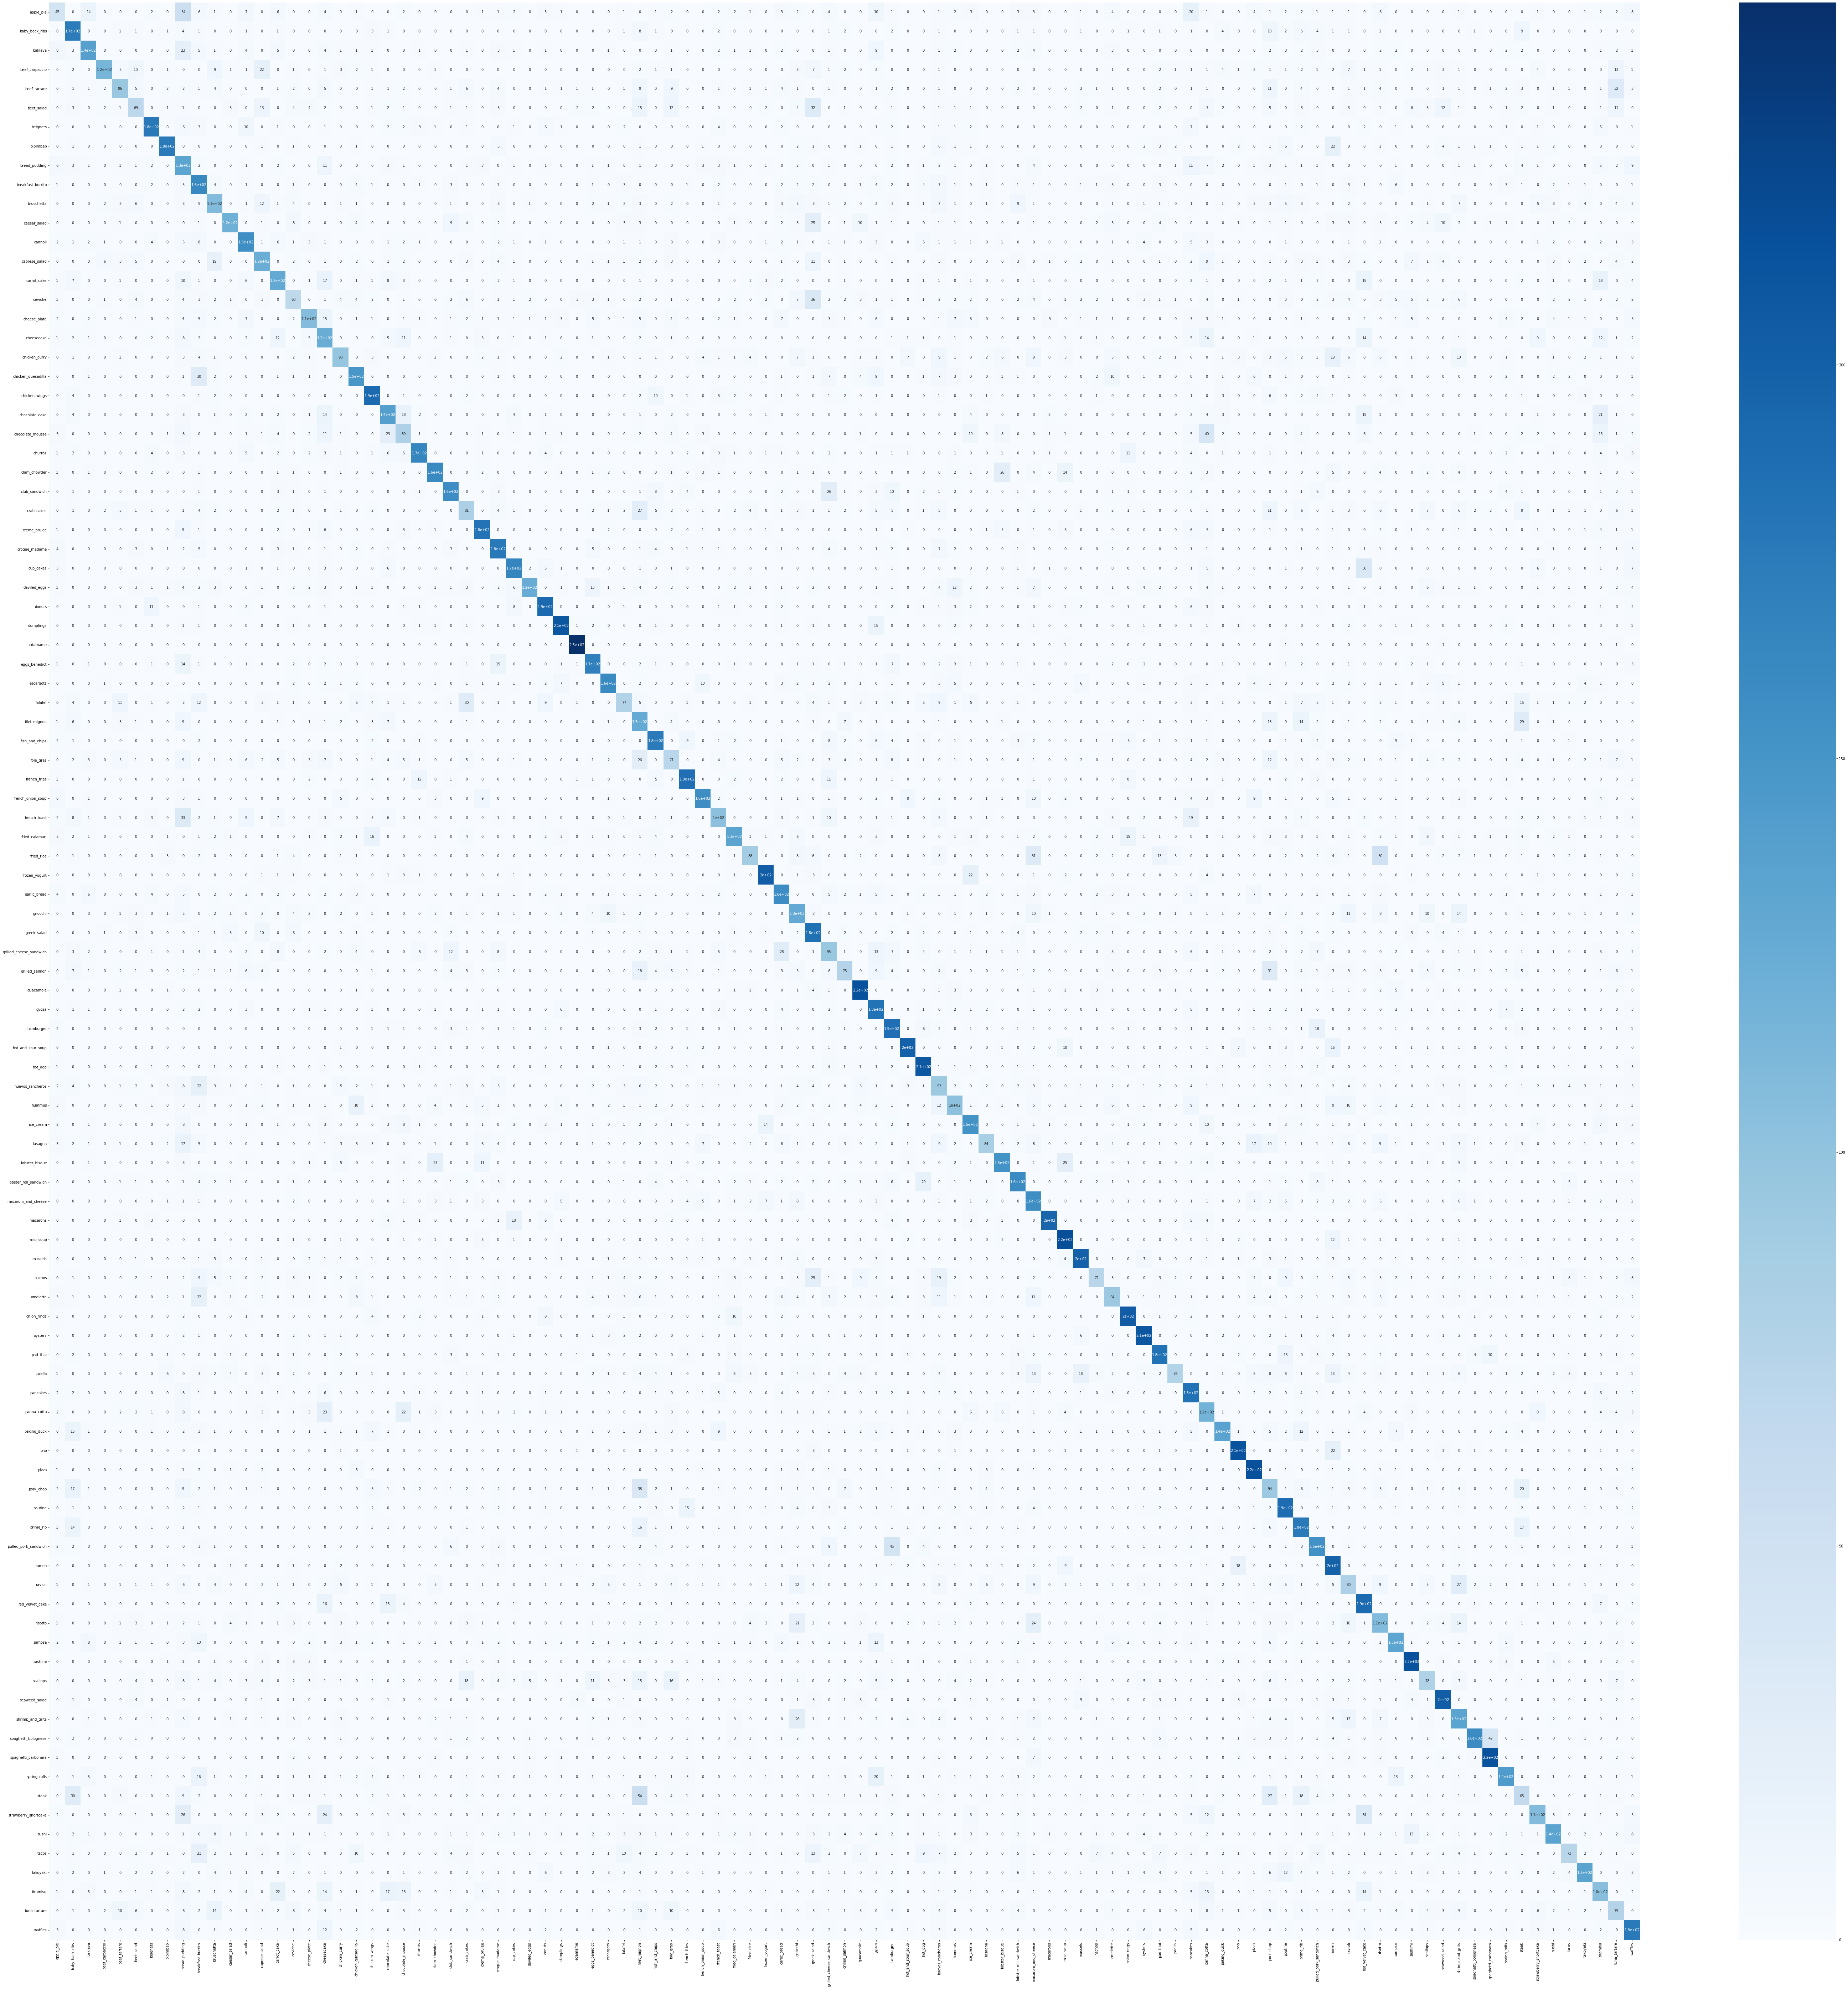

In [ ]:
cm = confusion_matrix(y_true = y_labels,
                      y_pred = pred_class)

plt.figure(figsize = (100,100))

sns.heatmap(cm,
            cmap = 'Blues',
            annot = True,
            xticklabels = test_data_10_percent.class_names,
            yticklabels = test_data_10_percent.class_names)

In [ ]:
print(classification_report(y_true = y_labels,
                            y_pred = pred_classes,
                            target_names = test_data_10_percent.class_names))

                         precision    recall  f1-score   support

              apple_pie       0.32      0.18      0.23       250
         baby_back_ribs       0.50      0.70      0.58       250
                baklava       0.68      0.55      0.61       250
         beef_carpaccio       0.85      0.46      0.60       250
           beef_tartare       0.58      0.38      0.46       250
             beet_salad       0.45      0.28      0.34       250
               beignets       0.76      0.71      0.73       250
               bibimbap       0.83      0.70      0.76       250
          bread_pudding       0.24      0.53      0.33       250
      breakfast_burrito       0.38      0.65      0.48       250
             bruschetta       0.47      0.44      0.45       250
           caesar_salad       0.79      0.48      0.60       250
                cannoli       0.60      0.62      0.61       250
          caprese_salad       0.51      0.49      0.50       250
            carrot_cake 

### 5.4 Visualising F1  Score for each Class
___

In [119]:
class_dict = classification_report(y_true = y_labels,
                                   y_pred = pred_classes,
                                   target_names = test_data_10_percent.class_names,
                                   output_dict = True)

In [127]:
class_f1_score = {}

for name , metrics in class_dict.items():
  if name == 'accuracy':
    break
  else:
    class_f1_score[name] = metrics['f1-score']

In [137]:
df_f1_score = pd.DataFrame(index = class_f1_score.keys(),
                           data = {'F1_score' : class_f1_score.values()})

In [138]:
df_f1_score

,F1_score
apple_pie,0.230769
baby_back_ribs,0.583893
baklava,0.610619
beef_carpaccio,0.599483
beef_tartare,0.462651
...,...
tacos,0.394595
takoyaki,0.626168
tiramisu,0.416667
tuna_tartare,0.315789


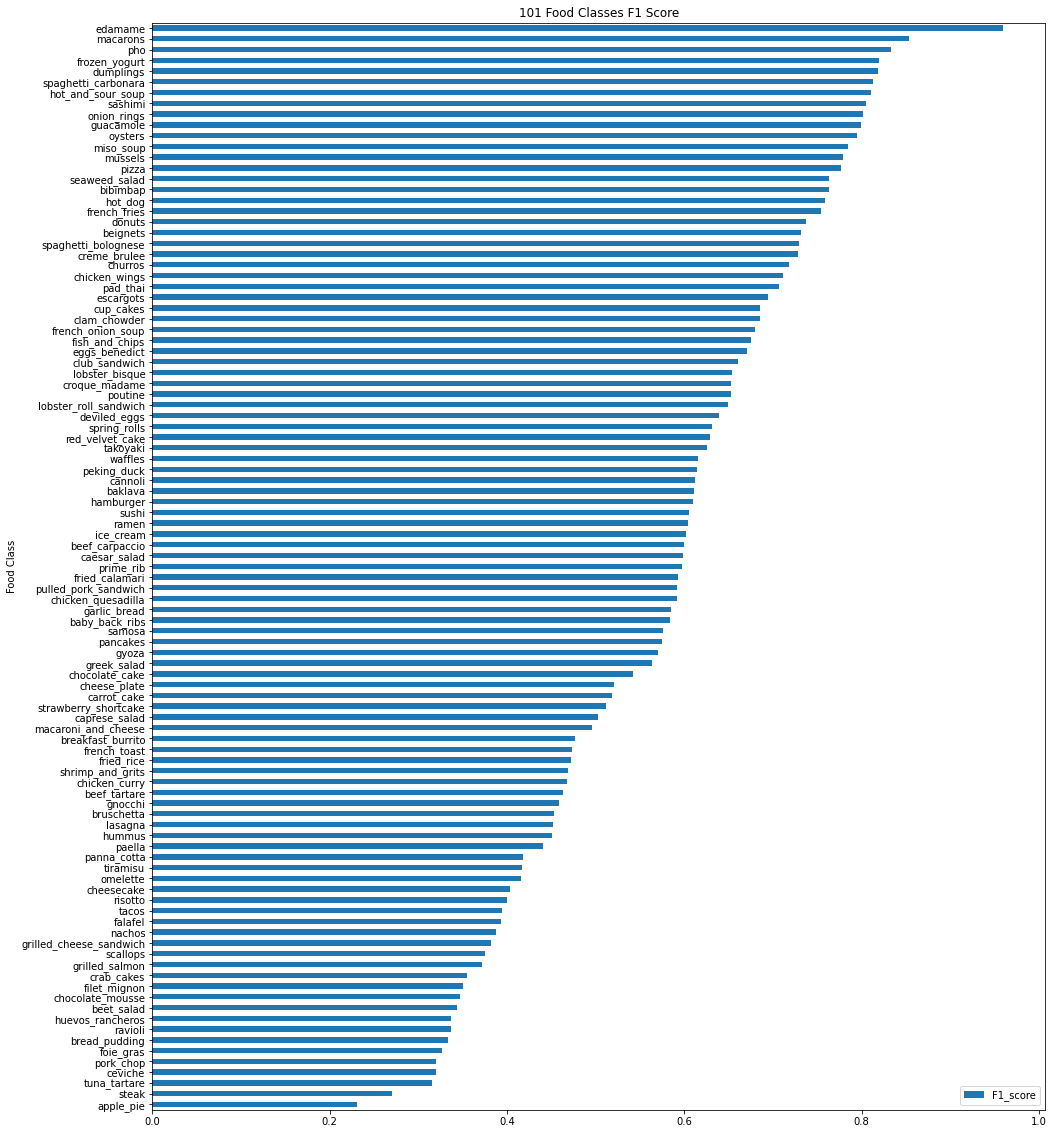

In [151]:
ax= df_f1_score.sort_values(by = 'F1_score' , ascending = False).plot(kind = 'barh' , figsize = (16,20))

ax.set_title('101 Food Classes F1 Score')
ax.set_ylabel('Food Class')
ax.invert_yaxis()